In [1]:
### https://pytorch.org/audio/stable/tutorials/speech_recognition_pipeline_tutorial.html
### https://colab.research.google.com/github/m3hrdadfi/soxan/blob/main/notebooks/Eating_Sound_Collection_using_Wav2Vec2.ipynb#scrollTo=Fv62ShDsH5DZ classification with pretrained transformer as base
### https://arxiv.org/abs/2006.11477 paper

In [1]:
from torch import nn
import numpy as np
from torch import Tensor
import torch
import torchaudio
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import os
import soundfile
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torchaudio.list_audio_backends())
TRAIN_DIR = './data/train/binary_classification/yes_no/'

cuda ['soundfile']


In [2]:
# loading data to dataset:
class SoundDataset(Dataset):

    def __init__(self, directory, gpu):
        self.directory = directory
        self.classes = os.listdir(directory)
        self.gpu = gpu
        self.class_to_num = {cl : i for i, cl in enumerate(self.classes)}
        self.num_to_class = {i : cl for i, cl in enumerate(self.classes)}
        paths = []
        for cl in self.classes:
            tmp = [os.path.join(directory+cl, path) for path in os.listdir(directory + cl)]
            paths+=tmp
        self.paths = paths
    
    
    def __len__(self):
        
        return len(self.paths)
    
    def __getitem__(self, index):
        audio_sample_path = self.paths[index]
        label = self.paths[index].split('/')[-1].split('\\')[0]

        signal, sr = torchaudio.load(audio_sample_path, format = 'wav')
        signal = signal[0]
        if self.gpu:
            signal.to(device)
        
        label_numeric = self.class_to_num[label]
        label_tensor = torch.tensor(label_numeric)
        return signal, label_tensor
        
        

In [3]:
dataset = SoundDataset(TRAIN_DIR, True)
train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 64, shuffle=True)

In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE #WAV2VEC2_ASR_BASE_960H 
model = bundle.get_model().to(device)
model

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

In [9]:
waveform = dataset[0][0]
waveform = waveform.reshape(1, -1).to(device)
model(waveform)[0].cpu().detach().numpy().shape

c:\Users\mipec\CUDA_kernel\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\mipec\CUDA_kernel\Lib\site-packages\torchaudio\models\wav2vec2\components.py:305: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


(1, 49, 768)

In [27]:
features = model.extract_features(waveform)[0]

In [31]:
features[-1].cpu().shape

torch.Size([1, 49, 768])

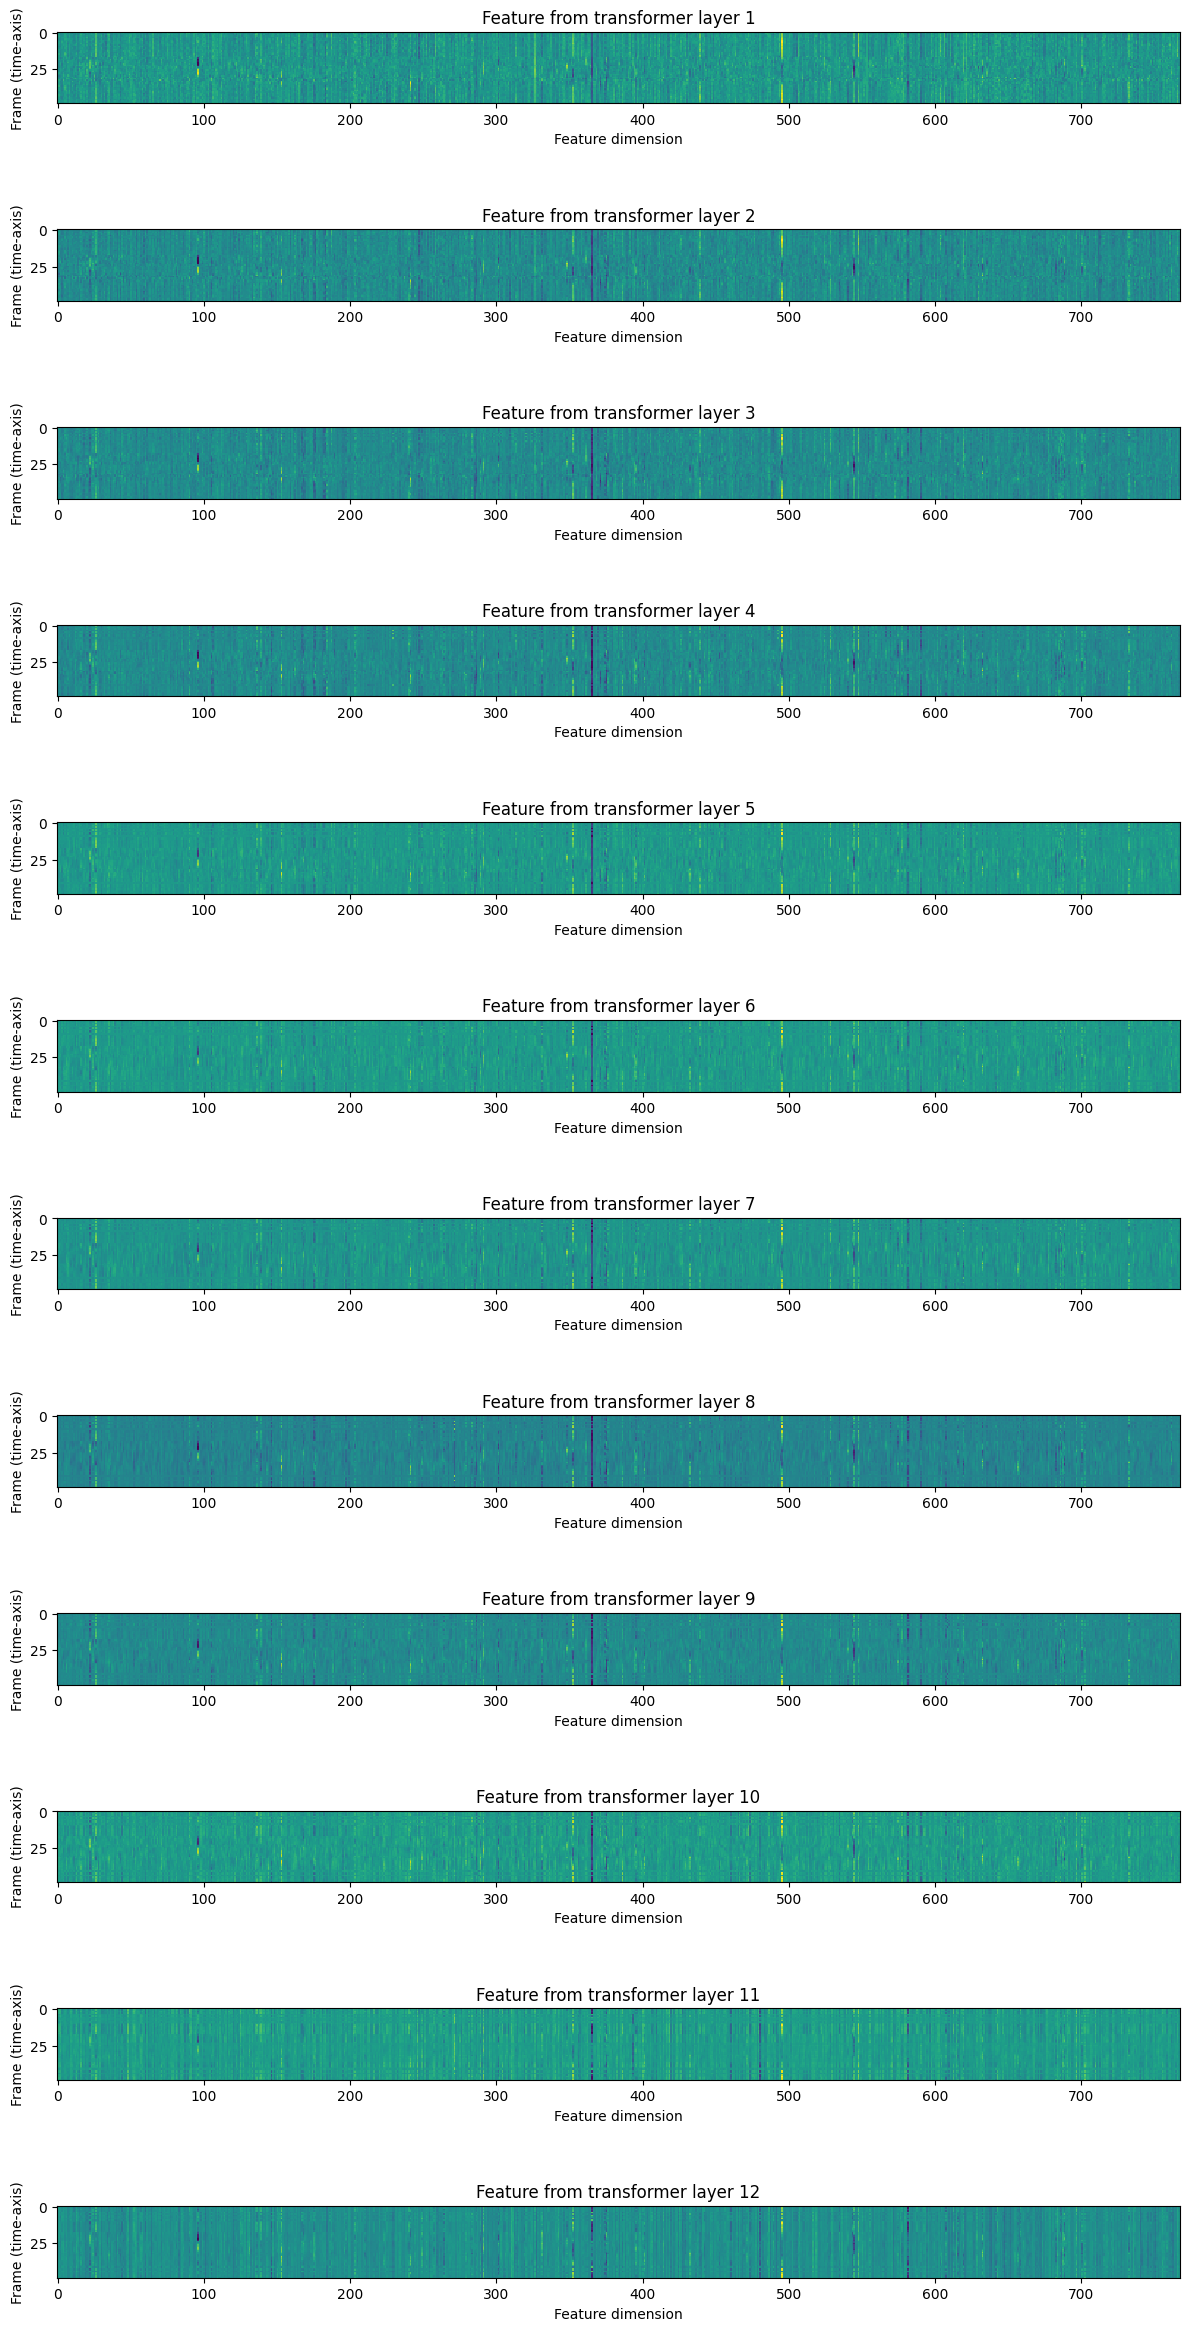

In [19]:
fig, ax = plt.subplots(len(features), 1, figsize=(12, 2 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats.detach()[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [3]:
class Wav2Vec2ClassificationModel(nn.Module):
    def __init__(self, num_labels, hidden_size, final_dropout = 0.1, pooling = 'mean'):
        super().__init__()
        self.base_model = torchaudio.pipelines.WAV2VEC2_BASE.get_model().to(device)
        self.classification_head = Wav2Vec2ClassificationHead(num_labels, hidden_size, final_dropout)
        self.pooling = pooling
        self.loss = []
        self.val_accuracy = []
        for param in self.base_model.feature_extractor.parameters():
                param.requires_grad = False

    def forward(self, inputs):
        # Get features from the base model
        features = self.base_model(inputs)[0] # 0 because it returns a tuple, we need only the first of the tuple

        # Pass features through the classification head
        logits = self.classification_head(features)

        return logits
    
    def predict(self, inputs):
        outputs = self.forward(inputs.to(device))
        if self.pooling == 'mean':
            predicted = torch.max(torch.mean(outputs, 1),1)[1]
        elif self.pooling == 'max':
            predicted = torch.max(torch.max(outputs, 1)[0],1)[1]
        elif self.pooling == 'sum':
            predicted = torch.max(torch.sum(outputs, 1),1)[1]
        return predicted

    

    def train_model(self, train_loader, val_loader, criterion, optimizer, num_epochs=10):
        for epoch in range(num_epochs):
            self.train()  # Set model to training mode
            for i, (batch_inputs, batch_labels) in enumerate(train_loader):
                optimizer.zero_grad()
                outputs = self(batch_inputs.to(device))
                batch_labels = batch_labels.to(device)
                if self.pooling == 'mean':
                    outputs = torch.mean(outputs, 1)
                elif self.pooling == 'max':
                    outputs = torch.max(outputs, 1)[0]
                elif self.pooling == 'sum':
                    outputs = torch.sum(outputs, 1)
                loss = criterion(outputs, batch_labels)
                # self.loss.append(loss.item().cpu())
                loss.backward()
                optimizer.step()
                print(f'batch number {i+1}/{len(train_loader)}, loss = { np.round(loss.item(), 4)}', end = '\r')

            # Validation
            self.eval()  # Set model to evaluation mode
            with torch.no_grad():
                total_correct = 0
                total_samples = 0
                for val_batch_inputs, val_batch_labels in val_loader:
                    val_outputs = self(val_batch_inputs.to(device))
                    
                    if self.pooling == 'mean':
                        predicted = torch.max(torch.mean(val_outputs, 1),1)[1]
                    elif self.pooling == 'max':
                        predicted = torch.max(torch.max(val_outputs, 1)[0],1)[1]
                    elif self.pooling == 'sum':
                        predicted = torch.max(torch.sum(val_outputs, 1),1)[1]
                    total_correct += (predicted == val_batch_labels.to(device)).sum().item() # TODO: this shit does not work, but will - predicted have to be class labels already, not logits
                    total_samples += val_batch_labels.size(0)
                accuracy = total_correct / total_samples
                self.val_accuracy.append(accuracy)

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Accuracy: {accuracy}')


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, num_labels, hidden_size, final_dropout):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(final_dropout)
        self.out_proj = nn.Linear(hidden_size, num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

# Binary classification - yes/no

In [3]:
dataset = SoundDataset(TRAIN_DIR, True)
train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64)

In [7]:
model_mean = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1, pooling = 'mean').to(device)
model_max = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1, pooling = 'max').to(device)
model_sum = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1, pooling = 'sum').to(device)
# Define data loaders for training and validation

### learning rate = 1e-4

In [8]:
for model in [model_mean, model_max, model_sum]:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
    print(model.pooling)
    model.train_model(train_loader, val_loader, criterion, optimizer, num_epochs=10)    

mean


c:\Users\mipec\CUDA_kernel\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\mipec\CUDA_kernel\Lib\site-packages\torchaudio\models\wav2vec2\components.py:305: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\mipec\CUDA_kernel\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._executi

Epoch [1/10], Loss: 0.00246197497472167, Validation Accuracy: 0.9863157894736843
Epoch [2/10], Loss: 0.0024985228665173054, Validation Accuracy: 0.988421052631579
Epoch [3/10], Loss: 0.0004656642850022763, Validation Accuracy: 0.9894736842105263
Epoch [4/10], Loss: 0.022296972572803497, Validation Accuracy: 0.9894736842105263
Epoch [5/10], Loss: 0.0001784675696399063, Validation Accuracy: 0.988421052631579
Epoch [6/10], Loss: 0.0010109550785273314, Validation Accuracy: 0.9926315789473684
Epoch [7/10], Loss: 0.01966177113354206, Validation Accuracy: 0.991578947368421
Epoch [8/10], Loss: 0.00012873753439635038, Validation Accuracy: 0.991578947368421
Epoch [9/10], Loss: 0.06394477188587189, Validation Accuracy: 0.9894736842105263
Epoch [10/10], Loss: 0.00012792818597517908, Validation Accuracy: 0.9894736842105263
max
Epoch [1/10], Loss: 0.002596749924123287, Validation Accuracy: 0.9852631578947368
Epoch [2/10], Loss: 0.003049516584724188, Validation Accuracy: 0.9873684210526316
Epoch [3/1

In [4]:
def plot_confusion_matrix(model, dataloader, classes, ax = None): # takes some time, because it requires for the model to pass through all the samples from the dataloader.
    true_labels = []
    predicted_labels = []
    for batch, labels in dataloader:
        predicted_labels+=list(model.predict(batch).cpu().numpy())
        true_labels+=list(labels.numpy())
    cm = confusion_matrix(true_labels, predicted_labels)
    ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=classes).plot(ax = ax, colorbar = False)
    return cm

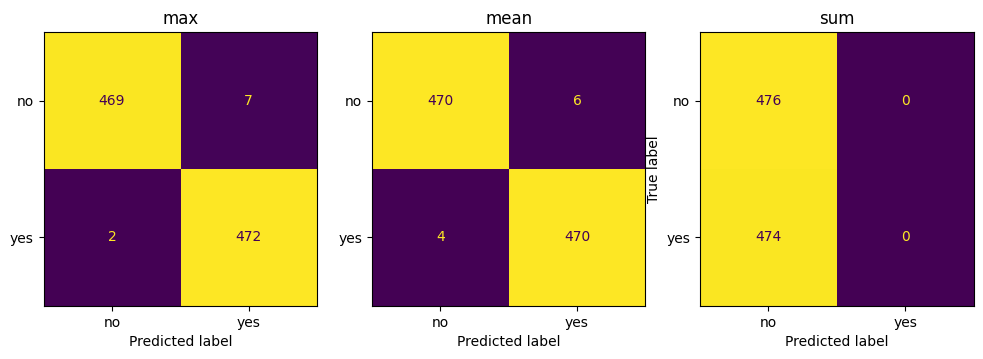

In [49]:
fig, axes = plt.subplots(1,3,figsize = (12, 8))
for ax, model in zip(axes, [model_max, model_mean, model_sum]):
    plot_confusion_matrix(model, validation_dataloader, dataset.classes, ax = ax)
    ax.set_title(model.pooling)
    ax.set_ylabel('')
ax.set_ylabel('True label')
plt.savefig('./media/wav2vec2lr1e4.png', dpi = 200)

### learning rate = 1e-3

In [8]:
model_mean = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1, pooling = 'mean').to(device)
model_max = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1, pooling = 'max').to(device)
model_sum = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1, pooling = 'sum').to(device)
for model in [model_mean, model_max, model_sum]:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    print(model.pooling)
    model.train_model(train_loader, val_loader, criterion, optimizer, num_epochs=10)

mean


c:\Users\mipec\CUDA_kernel\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\mipec\CUDA_kernel\Lib\site-packages\torchaudio\models\wav2vec2\components.py:305: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\mipec\CUDA_kernel\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._executi

Epoch [1/10], Loss: 0.7003269791603088, Validation Accuracy: 0.5021052631578947
Epoch [2/10], Loss: 0.7023974061012268, Validation Accuracy: 0.4978947368421053
Epoch [3/10], Loss: 0.714143693447113, Validation Accuracy: 0.4978947368421053
Epoch [4/10], Loss: 0.691228985786438, Validation Accuracy: 0.5021052631578947
Epoch [5/10], Loss: 0.6886671781539917, Validation Accuracy: 0.5021052631578947
Epoch [6/10], Loss: 0.694756269454956, Validation Accuracy: 0.4978947368421053
Epoch [7/10], Loss: 0.6934349536895752, Validation Accuracy: 0.5021052631578947
Epoch [8/10], Loss: 0.6944340467453003, Validation Accuracy: 0.4978947368421053
Epoch [9/10], Loss: 0.6921892762184143, Validation Accuracy: 0.5021052631578947
Epoch [10/10], Loss: 0.6920614838600159, Validation Accuracy: 0.4978947368421053
max
Epoch [1/10], Loss: 0.6698785424232483, Validation Accuracy: 0.5021052631578947
Epoch [2/10], Loss: 0.6835280060768127, Validation Accuracy: 0.5021052631578947
Epoch [3/10], Loss: 0.7015259265899658

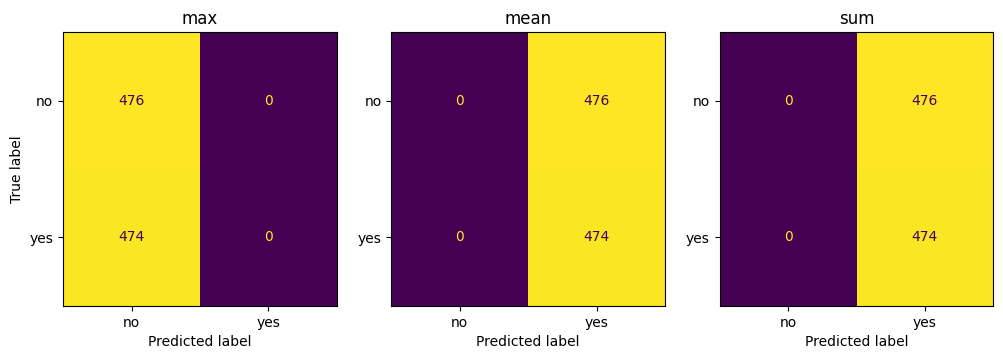

In [12]:
fig, axes = plt.subplots(1,3,figsize = (12, 8))
for ax, model in zip(axes, [model_max, model_mean, model_sum]):
    plot_confusion_matrix(model, validation_dataloader, dataset.classes, ax = ax)
    ax.set_title(model.pooling)
    ax.set_ylabel('')
axes[0].set_ylabel('True label')
plt.savefig('./media/wav2vec2lr1e3.png', dpi = 200)

### learning rate = 1e-5

In [7]:
model_mean = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1, pooling = 'mean').to(device)
model_max = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1, pooling = 'max').to(device)
model_sum = Wav2Vec2ClassificationModel(num_labels=2, hidden_size=768, final_dropout=0.1, pooling = 'sum').to(device)
for model in [model_mean, model_max, model_sum]:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
    print(model.pooling)
    model.train_model(train_loader, val_loader, criterion, optimizer, num_epochs=10)

mean


c:\Users\mipec\CUDA_kernel\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\mipec\CUDA_kernel\Lib\site-packages\torchaudio\models\wav2vec2\components.py:305: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\mipec\CUDA_kernel\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._executi

Epoch [1/10], Loss: 0.5373167395591736, Validation Accuracy: 0.98
Epoch [2/10], Loss: 0.025392046198248863, Validation Accuracy: 0.9831578947368421
Epoch [3/10], Loss: 0.01672094315290451, Validation Accuracy: 0.9926315789473684
Epoch [4/10], Loss: 0.08258379250764847, Validation Accuracy: 0.9863157894736843
Epoch [5/10], Loss: 0.025088123977184296, Validation Accuracy: 0.9852631578947368
Epoch [6/10], Loss: 0.2765144407749176, Validation Accuracy: 0.9842105263157894
Epoch [7/10], Loss: 0.024738214910030365, Validation Accuracy: 0.9842105263157894
Epoch [8/10], Loss: 0.25640541315078735, Validation Accuracy: 0.9926315789473684
Epoch [9/10], Loss: 0.009672791697084904, Validation Accuracy: 0.9905263157894737
Epoch [10/10], Loss: 0.00129074661526829, Validation Accuracy: 0.9863157894736843
max
Epoch [1/10], Loss: 0.0926118791103363, Validation Accuracy: 0.9736842105263158
Epoch [2/10], Loss: 0.023478997871279716, Validation Accuracy: 0.9852631578947368
Epoch [3/10], Loss: 0.0076991193927

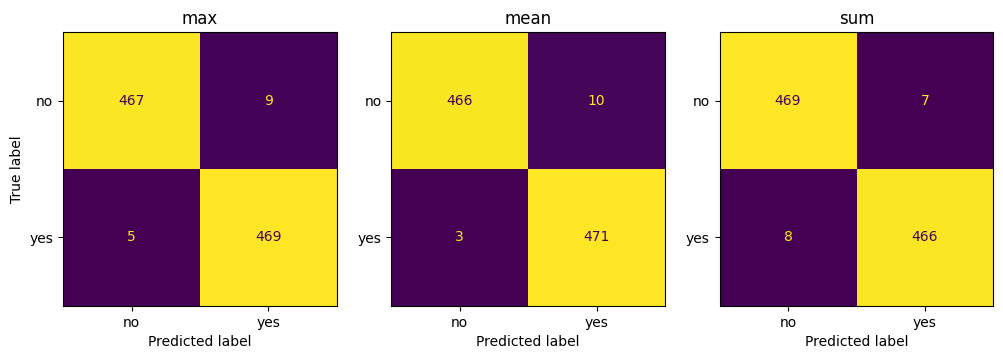

In [11]:
fig, axes = plt.subplots(1,3,figsize = (12, 8))
for ax, model in zip(axes, [model_max, model_mean, model_sum]):
    plot_confusion_matrix(model, val_loader, dataset.classes, ax = ax)
    ax.set_title(model.pooling)
    ax.set_ylabel('')
axes[0].set_ylabel('True label')
plt.savefig('./media/wav2vec2lr1e5.png', dpi = 200)

# whole dataset (30 classes)

In [5]:
dataset = SoundDataset('./data/train/padded/', True)

In [11]:
dataset.classes, len(dataset)

(['bed',
  'bird',
  'cat',
  'dog',
  'down',
  'eight',
  'five',
  'four',
  'go',
  'happy',
  'house',
  'left',
  'marvin',
  'nine',
  'no',
  'off',
  'on',
  'one',
  'right',
  'seven',
  'sheila',
  'six',
  'stop',
  'three',
  'tree',
  'two',
  'up',
  'wow',
  'yes',
  'zero'],
 64721)

In [8]:
from torch.utils.data import Subset
class_counts = {}
for _, label in dataset:
    label = label.item()
    if label not in class_counts:
        class_counts[label] = 0
    class_counts[label] += 1

# Calculate the desired number of samples for each class in training and validation sets
total_samples = len(dataset)
train_ratio = 0.8  # Adjust as needed
train_class_counts = {label: int(train_ratio * count) for label, count in class_counts.items()}
val_class_counts = {label: count - train_class_counts[label] for label, count in class_counts.items()}

# Create samplers for training and validation sets while maintaining class balance
train_indices = []
val_indices = []
shuffled_dataset = DataLoader(dataset, shuffle=True).dataset
for idx, (_, label) in enumerate(shuffled_dataset):
    if train_class_counts[label.item()] > 0:
        train_indices.append(idx)
        train_class_counts[label.item()] -= 1
    else:
        val_indices.append(idx)

train_dataset = Subset(shuffled_dataset, train_indices)
validation_dataset = Subset(shuffled_dataset, val_indices)

In [9]:
len(train_dataset), len(validation_dataset), len(dataset.classes)

(51764, 12957, 30)

In [10]:
validation_dataloader = DataLoader(validation_dataset, batch_size=64)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle = True)

In [13]:
full_model = Wav2Vec2ClassificationModel(num_labels=30, hidden_size=768, final_dropout=0.1, pooling = 'mean').to(device)
full_model.load_state_dict(torch.load('./media/full_W2V_epoch3.pth'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(full_model.parameters(), lr = 1e-5)
full_model.train_model(train_dataloader, validation_dataloader, criterion, optimizer, num_epochs=7)

c:\Users\mipec\CUDA_kernel\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\mipec\CUDA_kernel\Lib\site-packages\torchaudio\models\wav2vec2\components.py:305: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\mipec\CUDA_kernel\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._executi

Epoch [1/7], Loss: 0.21961364150047302, Validation Accuracy: 0.9628772092305318
Epoch [2/7], Loss: 0.0074935355223715305, Validation Accuracy: 0.9607162151732654


KeyboardInterrupt: 

In [14]:
torch.save(full_model.state_dict(), './media/full_W2V_epoch5.pth')

In [16]:
true_labels = []
predicted_labels = []
for batch, labels in validation_dataloader:
    predicted_labels+=list(full_model.predict(batch).cpu().numpy())
    true_labels+=list(labels.numpy())
cm = confusion_matrix(true_labels, predicted_labels)

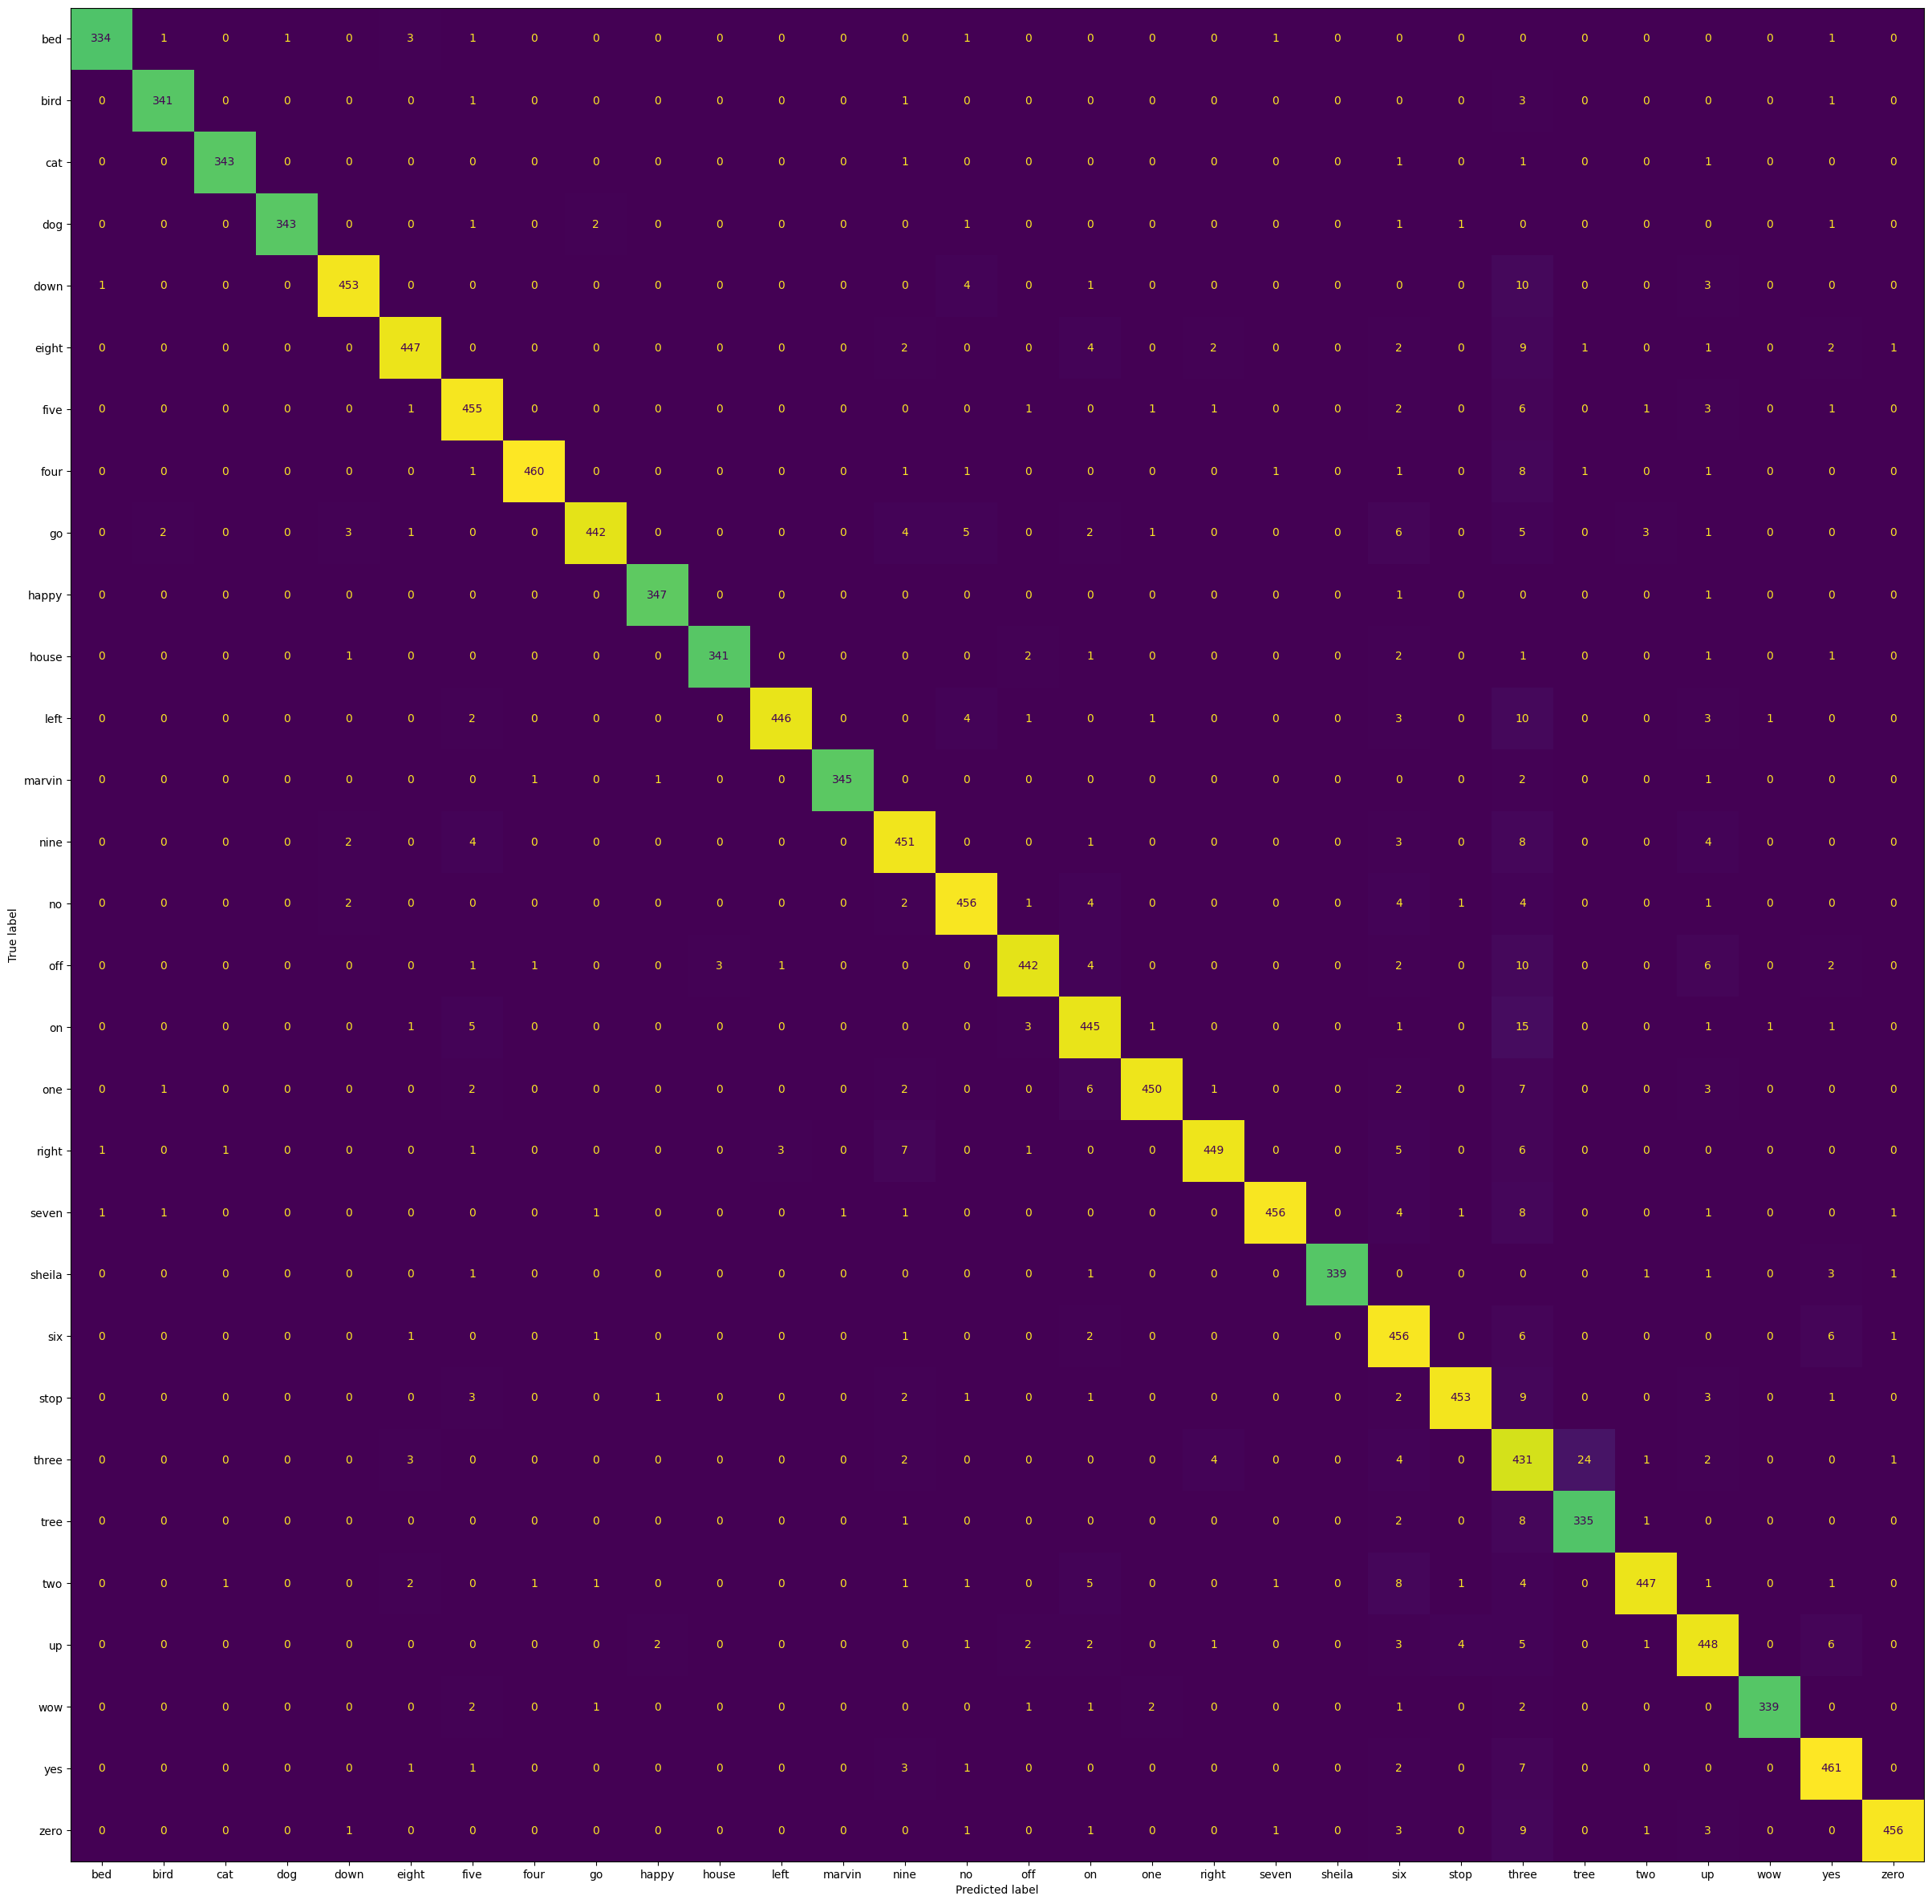

In [19]:
fig, ax = plt.subplots(1,1,figsize = (30,30))
ConfusionMatrixDisplay(cm, display_labels = dataset.classes).plot(ax = ax, colorbar = False)
plt.savefig('./media/wav2vec2full.png', dpi = 200)

In [20]:
diag = cm.diagonal()
np.fill_diagonal(cm, 0)

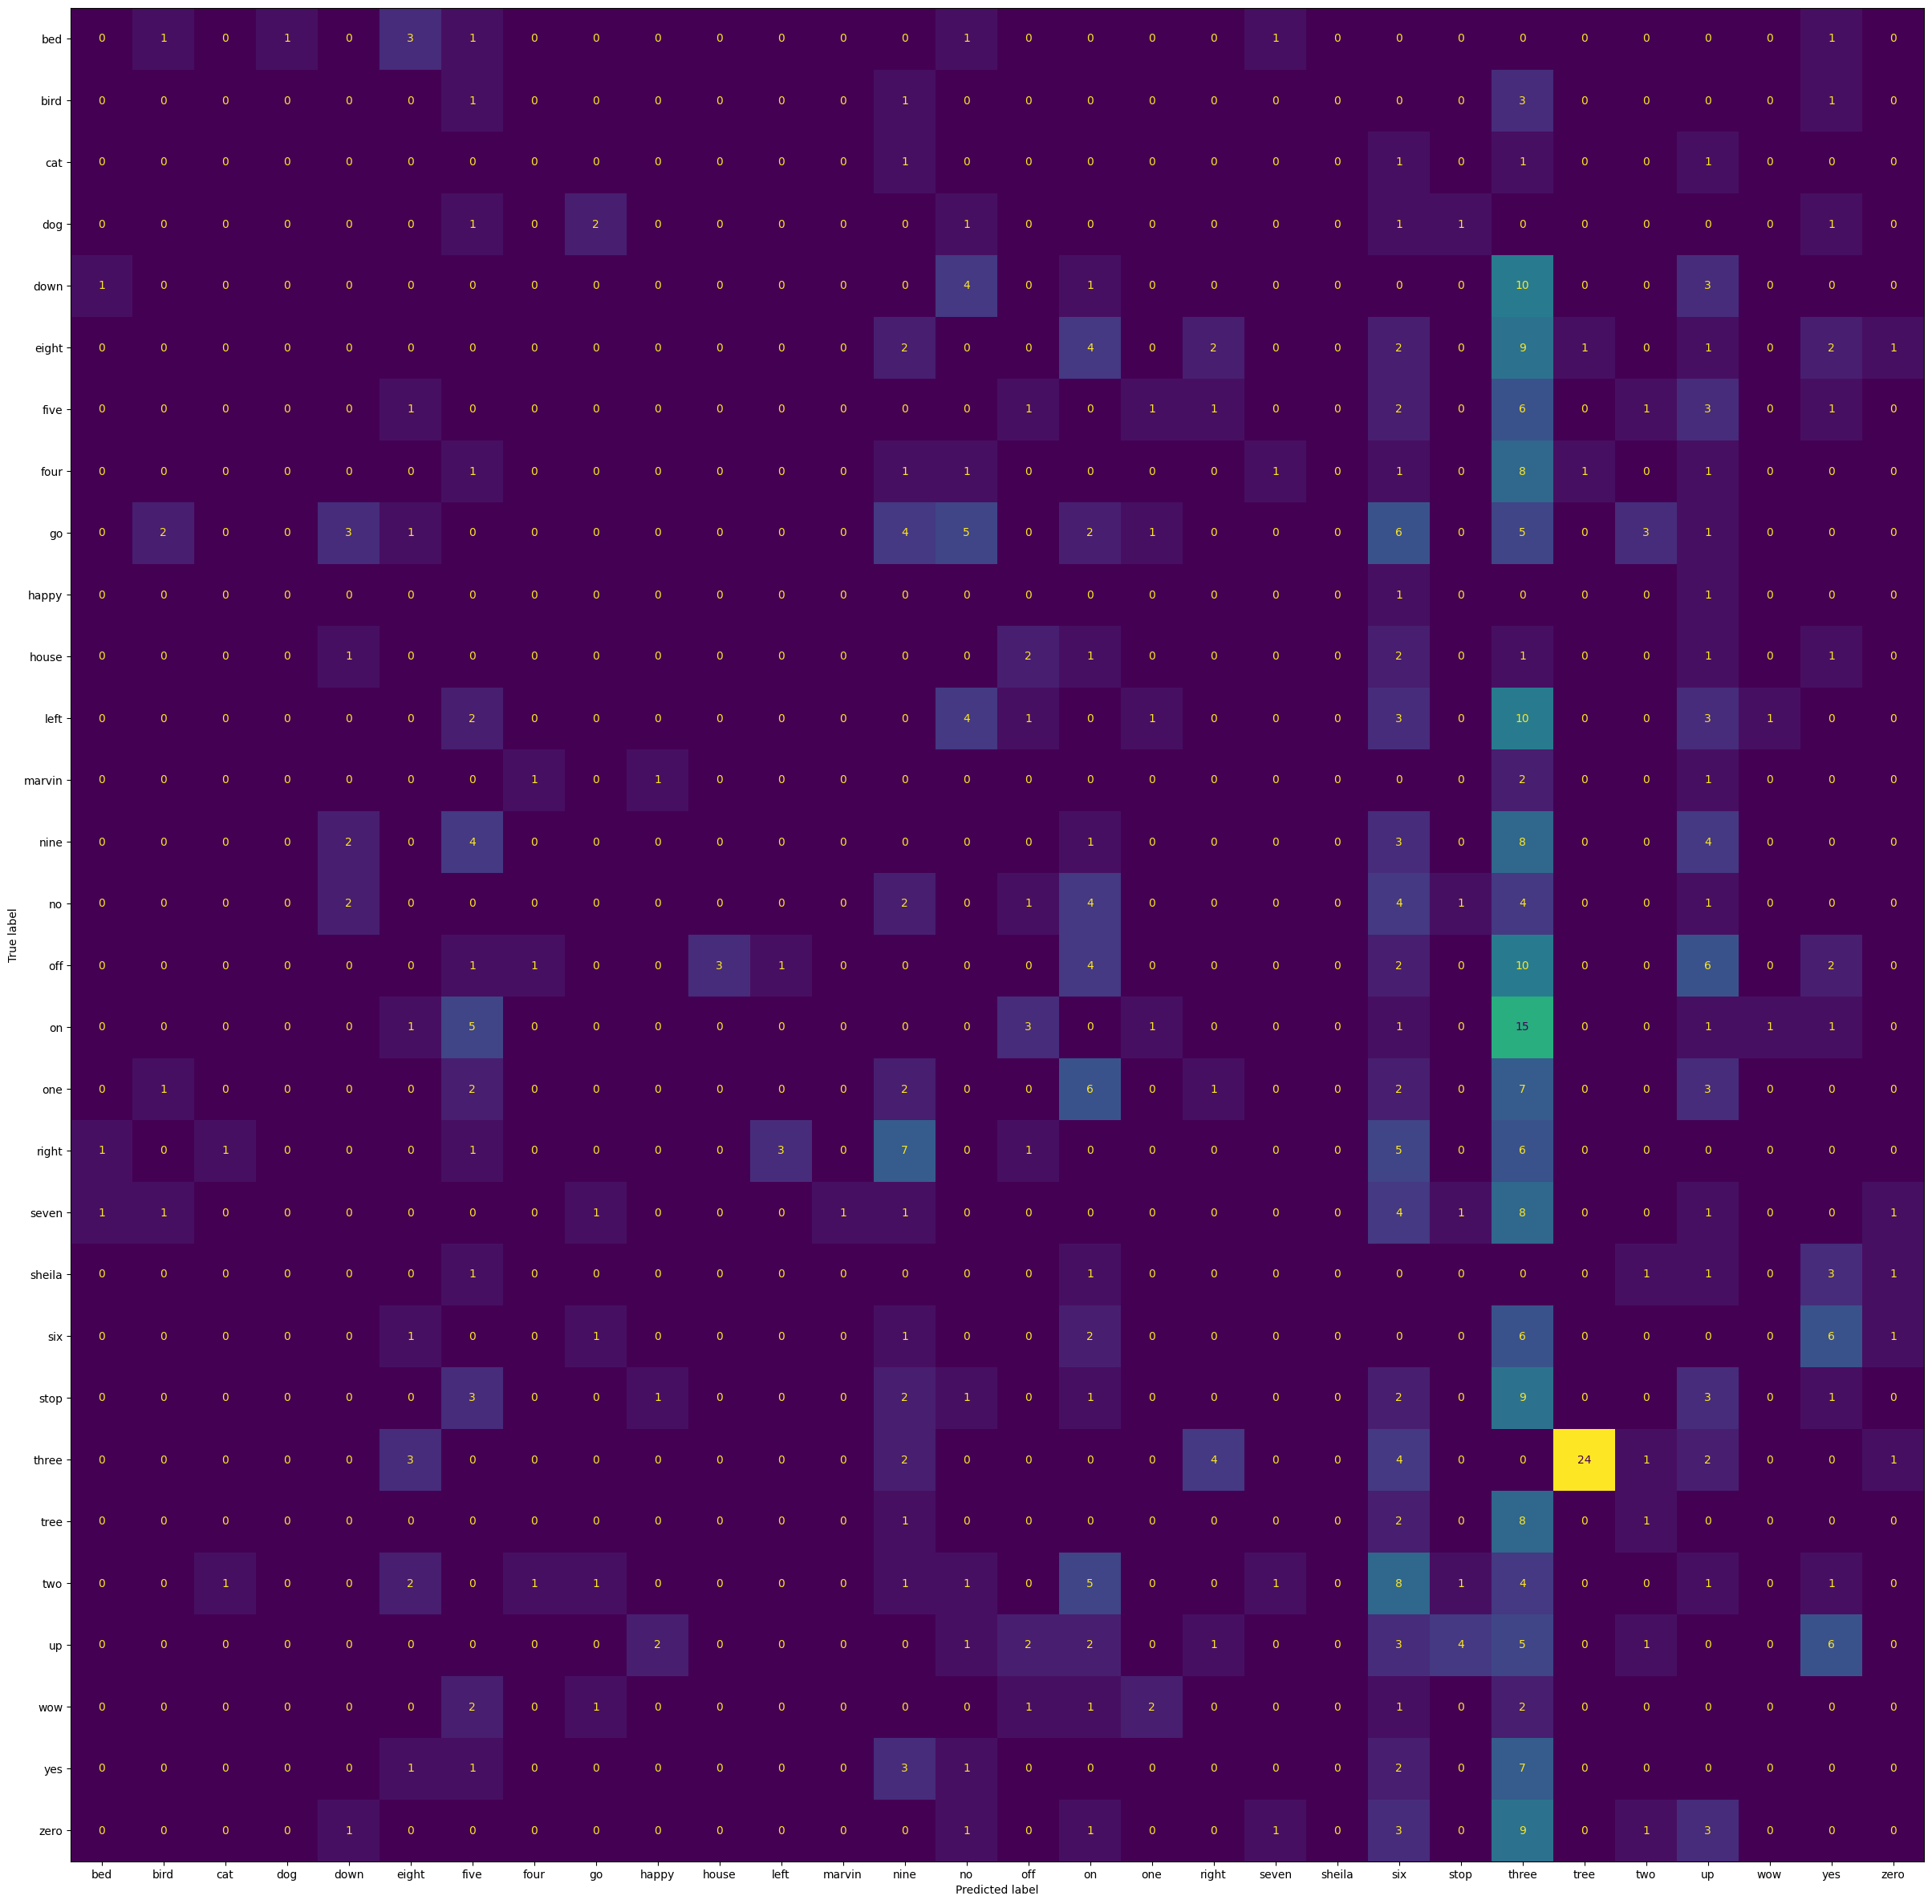

In [21]:
fig, ax = plt.subplots(1,1, figsize = (30,30))
ConfusionMatrixDisplay(cm, display_labels = dataset.classes).plot(ax = ax, colorbar=False)
plt.savefig('./media/wav2vec2full_errors.png', dpi = 200)

# error analysis

In [23]:
shuffled_dataset.class_to_num

{'bed': 0,
 'bird': 1,
 'cat': 2,
 'dog': 3,
 'down': 4,
 'eight': 5,
 'five': 6,
 'four': 7,
 'go': 8,
 'happy': 9,
 'house': 10,
 'left': 11,
 'marvin': 12,
 'nine': 13,
 'no': 14,
 'off': 15,
 'on': 16,
 'one': 17,
 'right': 18,
 'seven': 19,
 'sheila': 20,
 'six': 21,
 'stop': 22,
 'three': 23,
 'tree': 24,
 'two': 25,
 'up': 26,
 'wow': 27,
 'yes': 28,
 'zero': 29}

In [24]:
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
pred_24 = np.where(predicted_labels == 24)
pred_23 = np.where(predicted_labels == 23)
true_24 = np.where(true_labels == 24)
true_23 = np.where(true_labels == 23)

In [25]:
import librosa
from IPython.display import Audio

#### true three predicted as tree

In [26]:
y, sr = librosa.load(shuffled_dataset.paths[np.setdiff1d(true_23, pred_24)[0]])
Audio(data=y, rate=16000)

In [27]:
y, sr = librosa.load(shuffled_dataset.paths[np.setdiff1d(true_23, pred_24)[1]])
Audio(data=y, rate=16000)

In [28]:
y, sr = librosa.load(shuffled_dataset.paths[np.setdiff1d(true_23, pred_24)[2]])
Audio(data=y, rate=16000)

In [29]:
y, sr = librosa.load(shuffled_dataset.paths[np.setdiff1d(true_23, pred_24)[3]])
Audio(data=y, rate=16000)

In [30]:
y, sr = librosa.load(shuffled_dataset.paths[np.setdiff1d(true_23, pred_24)[4]])
Audio(data=y, rate=16000)